## Model Testing

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Add, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
feature_path='.../spectra_sheet_whole.csv'      
tbl = pd.read_csv(feature_path)
# tbl = tbl.set_index('ID')
print(tbl.shape)

(4440, 3815)


In [ ]:
tbl.head(5)

,281,282,283,284,285,286,287,288,289,290,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,3,1,0,0,0,2,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,2,2,1,0,1,2,1,3,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,2,0,5,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0


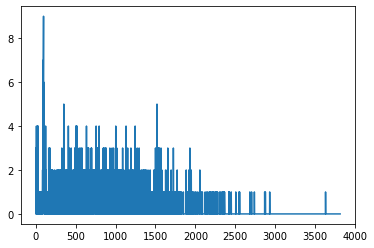

In [ ]:
row = tbl.loc[0,:]
row = np.expand_dims(row, axis = -1) 
plt.plot(row)

(3815, 1)

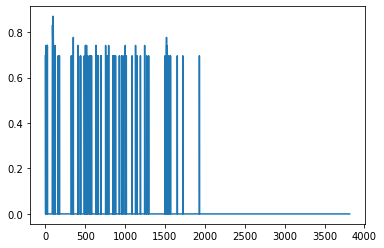

In [ ]:
def read_features(ID, desired_size = (3815,1), alpha = 0.5):
    try:    

        if alpha < 0.3:
            row = tbl.loc[ID,:]
            row[row < 3] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
            row = np.expand_dims(row, axis = -1)            
        else:  
            row = tbl.loc[ID,:]
            row[row < 3] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
            row = np.expand_dims(row, axis = -1)
    except:
        row = np.zeros(desired_size)        
    return row

a = read_features(0, (3815,1), 0.2)
plt.plot(a)
a.shape

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=64, dim=tbl.shape[1], n_channels=1,
                     augment =False, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self.__data_generation(list_IDs_temp)

        return X   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.augment:
                alpha = np.random.uniform(0,1)
            else:
                alpha = 0.5
            XXX = read_features(ID, alpha=alpha)
            X[i,] = XXX

#             y[i,] = read_gt(ID)

        return X

In [ ]:
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation = 'relu',input_shape=(tbl.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation="sigmoid", name='dense_output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3811, 64)          384       
_________________________________________________________________
batch_normalization (BatchNo (None, 3811, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1905, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1903, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1903, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 951, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 949, 64)           1

# Pigment Map generating

In [ ]:
# use either fine-tune or no finetune model 
model.load_weights('.../model/model_deeper_bg_13.hdf5')  #finetune_small

In [ ]:
test_generator = DataGenerator(tbl.index, 1, tbl.shape[1], 1, shuffle=False)
r = model.predict_generator(test_generator)

In [ ]:
r.shape

(4440, 13)

In [ ]:
classes = ['Cadmium yellow', 'Chromate yellow', 'Chromate green',  'Cobalt blue', 'Emerald green', 'Iron oxide',
       'Lead White','Prussian blue', 'Red lead', 'SnO2', 'Ultramarine blue', 'Vermilion', 'ZnO']

In [ ]:
dff = pd.DataFrame(data=r, columns= classes)

In [ ]:
dff.to_csv('pigment_map_noft_sheet_whole.csv', index = False)

In [ ]:
r

array([[1.99711323e-02, 3.30238640e-02, 3.86429518e-01, ...,
        5.34272850e-01, 3.38340104e-02, 3.37495059e-02],
       [5.71906567e-05, 3.31171036e-01, 1.36504173e-02, ...,
        8.79095793e-01, 1.16104424e-01, 9.23441172e-01],
       [2.93493271e-04, 5.61629176e-01, 3.35010439e-01, ...,
        9.63510573e-02, 4.89807189e-01, 9.18638170e-01],
       ...,
       [4.29153442e-05, 8.35694969e-01, 2.39115655e-02, ...,
        5.35455108e-01, 1.73978895e-01, 7.76704550e-01],
       [1.22687221e-03, 3.08311522e-01, 2.04230845e-02, ...,
        9.08372223e-01, 1.12561196e-01, 4.66869831e-01],
       [1.11680448e-01, 1.31500572e-01, 6.15878701e-02, ...,
        7.07357466e-01, 2.44018555e-01, 1.83545351e-01]], dtype=float32)